In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Hyper-parameters 
input_size = 784
hidden_size = 512
num_classes = 10

# for training:
batch_size = 128
learning_rate = 0.001
momentum = 0.9

In [ ]:
train_set = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transforms.ToTensor(), download=True)

test_set = torchvision.datasets.MNIST(
    root='./data', train=False,transform=transforms.ToTensor())

# Dataloaders
test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


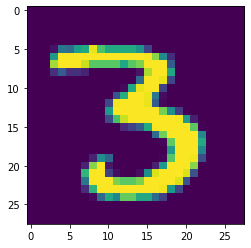

In [ ]:
# train_set[12] calls train_set.__getitem__(12)
# train_set[12][1] contains the label, here 3
plt.imshow(np.squeeze((train_set[12][0].numpy())))

In [ ]:
# or train_set.__len__()
len(train_set)

60000

In [ ]:
# Split the training data into training and validation parts.
# here we will use `torch.utils.data.SubsetRandomSampler`.

idx = np.arange(len(train_set))

# Use last 5000 images for validation
val_indices = idx[60000-5000:]
train_indices= idx[:-5000]

In [ ]:
print(len(val_indices))
print(len(train_indices))

5000
55000


In [ ]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          sampler=train_sampler, num_workers=2)

valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          sampler=valid_sampler, num_workers=2)

In [ ]:
class FFModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FFModel, self).__init__()
        self.fc1 = nn.Linear(input_size , hidden_size)
        self.fc2 = nn.Linear(hidden_size , num_classes)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        # Assume linealized input: here `images.view(−1, 28*28)`.
        out = self.fc1(x)
        out = self.activation(out)  # or F.relu.
        out = self.fc2(out)
        # second layer does not need activation function;
        # softmax is computed by cross entropy loss.
        return out

In [ ]:
model = FFModel(input_size , hidden_size , num_classes)
model = model.to(device)  # put all model params on GPU.

# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
print(model)

FFModel(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (activation): ReLU(inplace=True)
)


In [ ]:
torch.__version__

'1.9.0+cu111'

In [ ]:
# Training

num_epochs = 10

for epoch in range(1, num_epochs):
    running_loss = 0.0
    running_total = 0
    running_correct = 0
    run_step = 0
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        # shape of input images is (B, 1, 28, 28).
        images = images.view(-1, 28*28)  # reshape to (B, 784).
        images = images.to(device)
        labels = labels.to(device)  # shape (B).
        outputs = model(images)  # shape (B, 10).
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()  # reset gradients.
        loss.backward()  # compute gradients.
        optimizer.step()  # update parameters.

        running_loss += loss.item()
        running_total += labels.size(0)

        with torch.no_grad():
            _, predicted = outputs.max(1)
        running_correct += (predicted == labels).sum().item()
        run_step += 1
        if i % 200 == 0:
            # check accuracy.
            print(f'epoch: {epoch}, steps: {i}, '
                  f'train_loss: {running_loss / run_step :.3f}, '
                  f'running_acc: {100 * running_correct / running_total:.1f} %')
            running_loss = 0.0
            running_total = 0
            running_correct = 0
            run_step = 0

    # validate
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, 28*28)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_acc = 100 * correct / total
    print(f'Validation accuracy: {100 * correct / total} %')
    print(f'Validation error rate: {100 - 100 * correct / total: .2f} %')
print('Finished Training')

epoch: 1, steps: 0, train_loss: 2.307, running_acc: 10.2 %
epoch: 1, steps: 200, train_loss: 2.057, running_acc: 54.5 %
epoch: 1, steps: 400, train_loss: 1.416, running_acc: 75.8 %
Validation accuracy: 84.9 %
Validation error rate:  15.10 %
epoch: 2, steps: 0, train_loss: 1.028, running_acc: 80.5 %
epoch: 2, steps: 200, train_loss: 0.900, running_acc: 81.6 %
epoch: 2, steps: 400, train_loss: 0.700, running_acc: 84.4 %
Validation accuracy: 89.12 %
Validation error rate:  10.88 %
epoch: 3, steps: 0, train_loss: 0.738, running_acc: 80.5 %
epoch: 3, steps: 200, train_loss: 0.591, running_acc: 85.7 %
epoch: 3, steps: 400, train_loss: 0.520, running_acc: 87.1 %
Validation accuracy: 90.76 %
Validation error rate:  9.24 %
epoch: 4, steps: 0, train_loss: 0.562, running_acc: 84.4 %
epoch: 4, steps: 200, train_loss: 0.474, running_acc: 87.8 %
epoch: 4, steps: 400, train_loss: 0.458, running_acc: 88.0 %
Validation accuracy: 91.42 %
Validation error rate:  8.58 %
epoch: 5, steps: 0, train_loss: 0.5

In [ ]:
# Evaluation
with torch.no_grad():
    correct = 0
    total = 0
    model.eval() # Set model in eval mode. Don’t forget!
    for data in test_loader:
        images, labels = data
        images = images.view(-1, 28*28)
        images = images.to(device)
        labels = labels.to(device) # shape (B)
        outputs = model(images) # shape (B, num_classes)
        # ’outputs’ are logits (unnormalized log prob).
        # Model prediction is the class which has the highest 
        # probability according to the model ,
        # i.e. the class which has the highest logit value:
        _, predicted = outputs.max(dim=1)
        # predicted.shape: (B)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    print(f'Test accuracy: {test_acc} %')
    print(f'Test error rate: {100 - 100 * correct / total: .2f} %')

Test accuracy: 91.25 %
Test error rate:  8.75 %


## Section 2

In [ ]:
def create_dataset(means, std, sample_size, seed=None):
    random_state = np.random.RandomState(seed)
    X = np.zeros((sample_size, len(means[0])), dtype=np.float32)
    Y = np.zeros((sample_size , len(means)), dtype=np.float32)
    cov = np.eye(len(means[0])) * (std ** 2)
    for i in range(sample_size):
        c = random_state.randint(len(means))
        X[i] = random_state.multivariate_normal(means[c], cov)
        Y[i, c] = 1.
    return X, Y

In [ ]:
sample_size = 500
std = 0.5

X, Y = create_dataset([(-1, 1), (1, -1)], std, sample_size, 0)

labels = np.argmax(Y, axis=1)

X.shape

(500, 2)

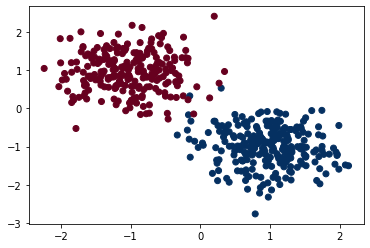

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=plt.cm.RdBu)

In [ ]:
X_train = torch.from_numpy(X).to(device)  # copy data to GPU.
labels = torch.from_numpy(labels).to(device)  # shape (B).

In [ ]:
# Model
input_size = 2
num_classes = 2
hidden_size = 256
learning_rate = 0.1
momentum = 0.9

model = FFModel(input_size , hidden_size , num_classes)
model = model.to(device)  # put all model params on GPU.
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
# Training

num_epochs = 100

for epoch in range(1, num_epochs):
    model.train()
    outputs = model(X_train)  # shape (B, 10).
    loss = loss_fn(outputs, labels)
    optimizer.zero_grad()  # reset gradients.
    loss.backward()  # compute gradients.
    optimizer.step()  # update parameters.
    print(loss.item())

0.8069146275520325
0.12225550413131714
0.030393214896321297
0.018049338832497597
0.015739068388938904
0.015452316030859947
0.015728214755654335
0.016176540404558182
0.016662783920764923
0.017133843153715134
0.017568957060575485
0.017960956320166588
0.01830935664474964
0.01861697994172573
0.018888238817453384
0.01912747137248516
0.019339295104146004
0.019527854397892952
0.01969669759273529
0.019848722964525223
0.019986212253570557
0.020110832527279854
0.020223768427968025
0.02032579481601715
0.020417366176843643
0.020498745143413544
0.020570075139403343
0.020631415769457817
0.02068287506699562
0.020724622532725334
0.02075730264186859
0.02078108862042427
0.020796144381165504
0.020803464576601982
0.020803168416023254
0.020795879885554314
0.02078230306506157
0.02076316438615322
0.020739199593663216
0.02071114256978035
0.020679660141468048
0.020645396783947945
0.02060895785689354
0.020571382716298103
0.02053314633667469
0.0204941239207983
0.020454639568924904
0.02041495032608509
0.020375244

In [ ]:
# Plotting decision boundary
grid_points = 100
grid_range = np.linspace(-3, 3, grid_points)

xx, yy = np.meshgrid(grid_range, grid_range)
X_test = np.zeros((grid_points * grid_points, 2))
X_test[:, 0] = xx.reshape(-1)
X_test[:, 1] = yy.reshape(-1)

In [ ]:
xx

array([[-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       ...,
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ]])

In [ ]:
zz = model(torch.from_numpy(X_test).float().to(device)).detach()
zz = torch.argmax(zz, 1)
zz = zz.reshape(grid_points, grid_points)  # (100, 100)
zz_cpu = zz.to('cpu').numpy()

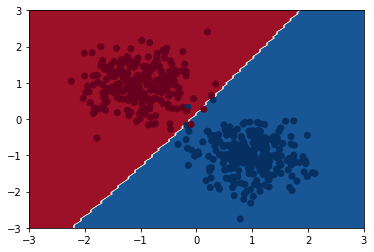

In [ ]:
plt.contourf(xx, yy, zz_cpu, cmap=plt.cm.RdBu)
plt.scatter(X[:, 0], X[:, 1], c=np.argmax(Y, axis=1), cmap=plt.cm.RdBu)

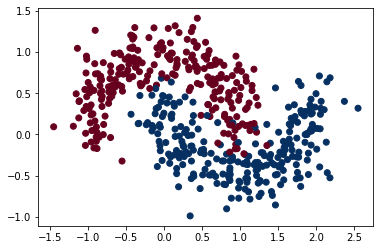

In [ ]:
# Try also this data

from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [ ]:
X_train = torch.from_numpy(X).to(device)  # copy data to GPU.
labels = torch.from_numpy(y).to(device)  # shape (B).

X_train = X_train.float()

In [ ]:
# Model
input_size = 2
num_classes = 2
hidden_size = 512
learning_rate = 0.1
momentum = 0.9

model = FFModel(input_size , hidden_size , num_classes)
model = model.to(device)  # put all model params on GPU.
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
# Training

num_epochs = 100

for epoch in range(1, num_epochs):
    model.train()
    outputs = model(X_train)  # shape (B, 10).
    loss = loss_fn(outputs, labels)
    optimizer.zero_grad()  # reset gradients.
    loss.backward()  # compute gradients.
    optimizer.step()  # update parameters.
    print(loss.item())

0.6912484169006348
0.5297375917434692
0.3745833933353424
0.4348207414150238
0.49523648619651794
0.48292139172554016
0.47651857137680054
0.4757867753505707
0.45566895604133606
0.4165985882282257
0.3954399526119232
0.41556063294410706
0.41165798902511597
0.40298500657081604
0.3969293236732483
0.3511301875114441
0.3108482360839844
0.29841509461402893
0.2701471447944641
0.2590487003326416
0.2550284266471863
0.23887017369270325
0.24076925218105316
0.23383072018623352
0.2365431934595108
0.2370949238538742
0.23391415178775787
0.22334757447242737
0.21181650459766388
0.19838669896125793
0.18830715119838715
0.18503175675868988
0.179693341255188
0.180831640958786
0.1794436275959015
0.17724305391311646
0.17700399458408356
0.17383000254631042
0.17025434970855713
0.16792935132980347
0.16382412612438202
0.15995846688747406
0.15746843814849854
0.15381857752799988
0.1510435789823532
0.14919818937778473
0.14667576551437378
0.14521320164203644
0.14400658011436462
0.14226239919662476
0.14123223721981049
0

In [ ]:
# Plotting decision boundary
grid_points = 100
grid_range = np.linspace(-2, 2.5, grid_points)

xx, yy = np.meshgrid(grid_range, grid_range)
X_test = np.zeros((grid_points * grid_points, 2))
X_test[:, 0] = xx.reshape(-1)
X_test[:, 1] = yy.reshape(-1)

In [ ]:
zz = model(torch.from_numpy(X_test).float().to(device)).detach()
zz = torch.argmax(zz, 1)
zz = zz.reshape(grid_points, grid_points)  # (100, 100)
zz_cpu = zz.to('cpu').numpy()

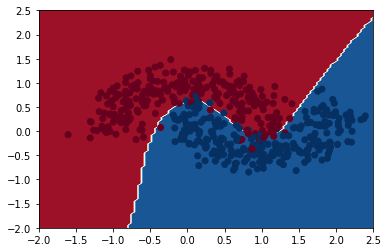

In [ ]:
plt.contourf(xx, yy, zz_cpu, cmap=plt.cm.RdBu)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [ ]:
# what if the model had more layers?